# Example: Trapped UH in Mast Upgrade

In [2]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import torch_func
from diff_func_fitters import fit_polynomial, fit_rational_func, SumFunc, FiniteDiffFunc1D
from gauss_freud_quad import get_nodes_and_weights
from scipy.optimize import brentq
from baryrat import aaa

import mgo

In [3]:
# Define Warm Plasma Dispersion Relation
import torch
from scipy.constants import e, m_e, epsilon_0, c

# ICs
f0 = 68.4463e9
omega0 = 2*np.pi*f0

# Constants
n0 = 0.255e19
T0 = 100*e
L_ne = 8e-3
B0 = 2.4

@torch_func
def B(x: ('scalar')):
    return B0 * torch.ones_like(x)

@torch_func
def omega_c(x: ('scalar')):
    return e*B(x)/m_e

@torch_func
def T_e(x: ('scalar')):
    return T0

@torch_func
def n_e(x: ('scalar')):
    return n0 * torch.exp(-(x/L_ne)**2)

@torch_func
def omega_p_squared(x: ('scalar')):
    return n_e(x) * e**2 / (epsilon_0 * m_e)

@torch_func
def v_Te_squared(x: ('scalar')):
    return 2*T_e(x)/m_e

@torch_func
def Stix_S(x: ('scalar'), omega: ('scalar')):
    return 1 - (omega_p_squared(x)/(omega**2 - (omega_c(x)**2 )))

@torch_func
def Stix_D(x: ('scalar'), omega: ('scalar')):
    return (omega_c(x)/omega) * (omega_p_squared(x)/(omega**2 - (omega_c(x)**2)))

@torch_func
def lamb(x: ('scalar'), k: ('scalar')):
    return v_Te_squared(x)/(2 * (omega_c(x)**2)) * (torch.abs(k)**2)

@torch_func
def Omega(x: ('scalar'), omega: ('scalar')):
    return omega/omega_c(x)

@torch_func
def K1_int(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    _psi = torch.linspace(0, torch.pi, 100)
    return (torch.exp(-lamb(x, k))
            * torch.trapezoid(
            (torch.sin(torch.outer(_psi, Omega(x, omega).reshape(-1)))
                * torch.outer(torch.sin(_psi), torch.ones_like(x.reshape(-1)))
                * torch.exp(
                    - torch.outer(torch.cos(_psi), lamb(x, k).reshape(-1))
                    )
            ), _psi, dim=0)
            )

@torch_func
def K1(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return ((torch.sin(torch.pi * Omega(x, omega)))
     + (omega_p_squared(x)/(omega_c(x)**2))
        * (K1_int(x, k, omega))
    )

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return ((c/omega)**2 *
            (K1(x, k, omega) * (torch.abs(k)**2)
             - (torch.sin(torch.pi * Omega(x, omega)))*(omega/c)**2 *
             (Stix_S(x, omega)**2 - Stix_D(x, omega)**2)))

def D_vec(x, k, omega):
    return D(x.flatten(), k.flatten(), omega.flatten()).reshape(x.shape)

def get_k0(x0, omega0, kmin, kmax):
    return brentq(lambda k: D(x0, k, omega0), kmin, kmax)

#### Test Dispersion on a $(x, k, \omega)$ point

In [4]:
k0 = 10e3
f0 = f0
omega0 = 2*np.pi*f0
x0 = 0

print(
    'B', B(x0),
    '\n omega_c', omega_c(x0),
    '\n n_e', n_e(x0),
    '\n omega_p_squared', omega_p_squared(x0),
    '\n Stix_S', Stix_S(x0, omega0),
    '\n Stix_D', Stix_D(x0, omega0),
    '\n lambd', lamb(x0, k0),
    '\n v_Te_squared', v_Te_squared(x0),
    '\n K1_int', K1_int(x0, k0, omega0),
    '\n K1', K1(x0, k0, omega0),
    '\n D', D(x0, k0, omega0)
)

B tensor(2.4000) 
 omega_c tensor(4.2212e+11) 
 n_e tensor(2.5500e+18) 
 omega_p_squared tensor(8.1154e+21) 
 Stix_S tensor(-0.1988) 
 Stix_D tensor(1.1766) 
 lambd tensor(0.0099) 
 v_Te_squared 35176400215443.266 
 K1_int tensor([1.5398]) 
 K1 tensor([0.0110]) 
 D tensor([0.4571])


In [5]:
# omega_T = torch.tensor(omega0, requires_grad=True)
# x_T = torch.tensor(float(x0), requires_grad=True)
# k_T = torch.tensor(float(k0), requires_grad=True)
# D_test = D(x_T, k_T, omega_T)

# D_test.backward()
# grad_x = x_T.grad
# grad_k = k_T.grad
# RHS_x = - grad_k
# RHS_k = grad_x

#### Plot Dispersion in $(k, f)$ space

In [6]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

k0 3747.2210693359357  m^-1


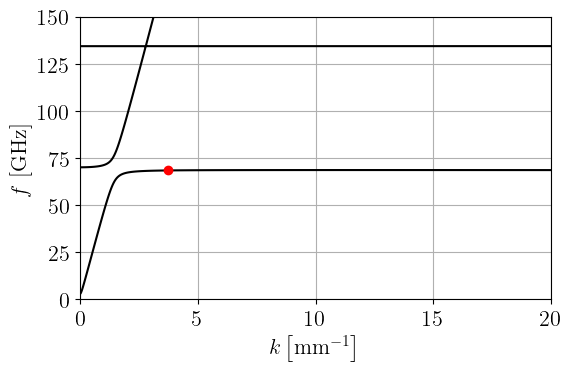

In [7]:
f0 = f0
omega0 = 2*np.pi*f0
x0 = 0
ki = np.linspace(0, 20e3, 1000)
omegai = 2*np.pi*np.linspace(1e-6, 150e9, 1000)
K, O = np.meshgrid(ki, omegai, indexing='ij')

k0 = get_k0(x0, omega0, 0, 10000)
print('k0', k0, ' m^-1')

plt.figure(figsize=(6, 4))
plt.contour(K * 1e-3, O/(2*np.pi) * 1e-9, D_vec(x0*np.ones_like(K), K, O), levels=[0], colors=['k'])
# plt.plot(plt.gca().get_xlim(), [f0 * sc_omega * 1e-9, f0 * sc_omega * 1e-9], '--', linewidth=1)
plt.plot(k0*1e-3, f0 * 1e-9, 'ro')
plt.ylabel(r'$f$ [GHz]')
plt.xlabel(r'$k \, \mathrm{\left[ mm^{-1} \right]}$')
plt.tight_layout()
plt.grid()
# plt.savefig('./plots/Trapped_UH_dispersion.pdf')
# plt.savefig('./plots/Trapped_UH_dispersion.png', dpi=600)
plt.show()

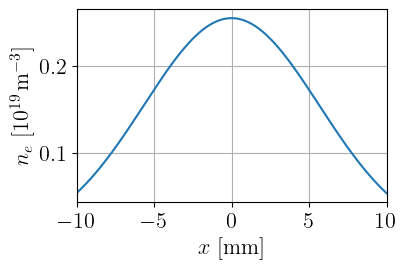

In [8]:
xi = np.linspace(-10e-3, 10e-3, 200)

plt.figure(figsize=(4,2.5))
plt.plot(xi*1e3, n_e(xi)*1e-19)
# plt.plot([0, 16], [omega0*1e-9, omega0*1e-9])
# plt.plot(xi, omega_c(xi)*1e-9)
# plt.plot(xi, np.sqrt(omega_p_squared(xi))*1e-9)
plt.xlim(-10, 10)
plt.xlabel('$x$ [mm]')
plt.ylabel(r'$n_e$ [$10^{19} \, \mathrm{m^{-3}}$]')
plt.grid()
plt.show()

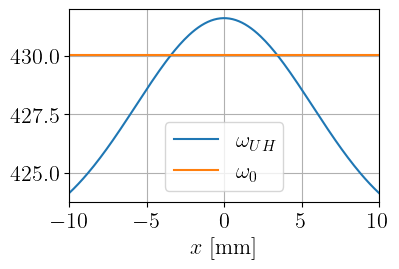

In [9]:
xi = np.linspace(-10e-3, 10e-3, 200)

plt.figure(figsize=(4,2.5))
plt.plot(xi*1e3, np.sqrt(omega_c(xi)**2 + omega_p_squared(xi))*1e-9, label=r'$\omega_{{UH}}$')
plt.plot(xi*1e3, omega0*np.ones_like(xi)*1e-9, label=r'$\omega_0$')
# plt.plot([0, 16], [omega0*1e-9, omega0*1e-9])
# plt.plot(xi, omega_c(xi)*1e-9)
# plt.plot(xi, np.sqrt(omega_p_squared(xi))*1e-9)
plt.xlim(-10, 10)
plt.xlabel('$x$ [mm]')
plt.legend()
plt.grid()
plt.show()

In [10]:
max_gauss_quad_order = 3

def get_dispersion_manifold(x0, k0, omega0):
    ND = 1
    nt = 6000
    t, xs, ks, zs, i_start, i_end = trace_ray_1D(x0=x0, k0=k0, omega0=omega0, tmin=0, tmax=180e-9, D=D, x_max = -1e-6, tsteps=nt, ghost_ratio=0.05, solve_ivp_args={'method': 'LSODA'}, true_time=True, rtol=1e-9)
    nt = i_end - i_start
    return t, xs, ks, zs, nt, i_start, i_end, x0, k0

def get_mgo_field(phi0, t, zs, i_start, i_end, i_save=[],
                       analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 20}},
                       'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 20}}},):
    branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0, i_start, i_end, i_save=i_save, analytic_cont=analytic_cont, max_gauss_quad_order=max_gauss_quad_order)
    results = mgo_info['saved_results']
    Nt = mgo_info['Nt']
    Upsilon = mgo_info['Upsilon']
    return branch_masks, ray_field, mgo_info, results, Nt, Upsilon

In [10]:
# nt = 8000
# for f0 in 68.4463e9 + np.arange(-1, 2)*0.0001e9:
#     print('f0', f0)
#     omega0 = 2*np.pi*f0
#     k0 = get_k0(x0, omega0, 0, 10000)
#     t, xs, ks, zs, i_start, i_end = trace_ray_1D(x0=x0, k0=k0, omega0=omega0, tmin=0, tmax=180e-9, D=D, x_max = -1e-6, tsteps=nt, ghost_ratio=0.05, solve_ivp_args={'method': 'LSODA'}, true_time=True, rtol=1e-9)
#     nt = i_end - i_start
#     print('f0', f0, '. QTZ:', np.trapz(ks[i_start:i_end].squeeze(), xs[i_start:i_end].squeeze()) / (np.pi))

In [11]:
t, xs, ks, zs, nt, i_start, i_end, x0, k0 = get_dispersion_manifold(x0, k0, omega0)
S = mgo.get_symplectic_tangent_trfm(zs, t, 1, i_start, i_end)
i_caust = np.argmin(np.abs(S[:, 0, 0]))
i_dt = int(0.2*nt)
i_save = np.arange(i_caust - i_dt, i_caust + i_dt, int(2*i_dt/4))

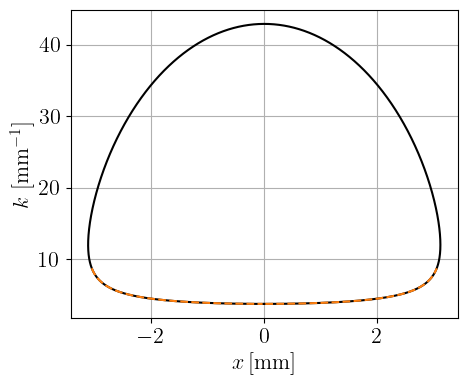

In [12]:
plt.figure(figsize=(5, 4))
plt.plot(xs[i_start:i_end]*1e3, ks[i_start:i_end]*1e-3, color='k')
plt.plot(xs[:i_start]*1e3, ks[:i_start]*1e-3, '--', color='tab:orange')
plt.plot(xs[i_end:]*1e3, ks[i_end:]*1e-3, '--', color='tab:orange')
plt.ylabel(r'$k \,\, [\mathrm{mm^{-1}}]$')
plt.xlabel(r'$x \, [\mathrm{mm}]$')
plt.grid()
plt.show()

### Quantization Criterion

In [13]:
np.trapz(ks[i_start:i_end].squeeze(), xs[i_start:i_end].squeeze()) / (np.pi)

-60.98711439518495

In [14]:
phi0 = 1
analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 10}}, 'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 10}}}

mgo_branch_masks, mgo_ray_field, info, results, Nt, Upsilon = get_mgo_field(phi0, t, zs, i_start, i_end, i_save=i_save, analytic_cont=analytic_cont)

epsmax is zero at it_all: 2983 it: 2684                                         


/Users/rune.hoejlund/Development/DTU/plasma-ray-tracer/mgo.py:234: RuntimeWarning: divide by zero encountered in scalar divide
  max_extrapolation = 1 + wavelength/(2*epsmax)
/Users/rune.hoejlund/Development/DTU/plasma-ray-tracer/mgo.py:299: RuntimeWarning: invalid value encountered in scalar multiply
  epsmax = max_extrapolation * _get_max_abs(eps_all)
/Users/rune.hoejlund/Development/DTU/plasma-ray-tracer/mgo.py:148: UserWarning: error finding steepest descent direction. will reuse last iterations direction
  warn('error finding steepest descent direction. will reuse last iterations direction')


epsmax is zero at it_all: 2983: 2684                                            


IndexError: list assignment index out of range

In [ ]:
plt.plot(np.real(mgo_ray_field))

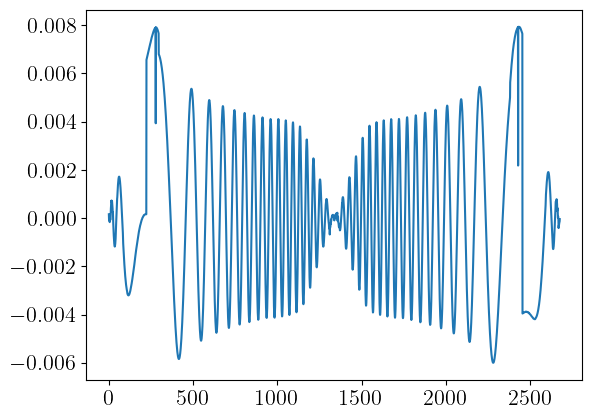

In [24]:
plt.plot(np.real(mgo_ray_field))

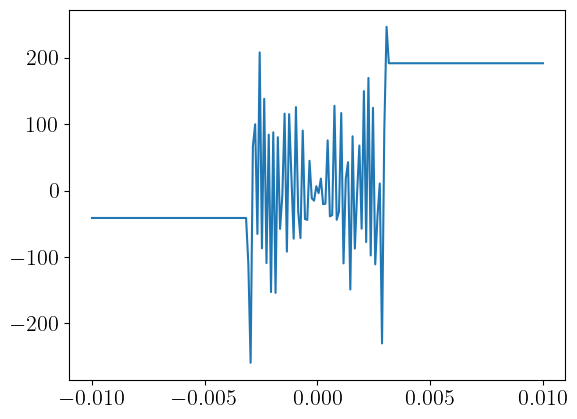

In [33]:
mgo_field = mgo.superpose_ray_fields(phi0=phi0, x0=x0, xs=xs, branch_masks=mgo_branch_masks, ray_field=mgo_ray_field,
                                     i_start=i_start, i_end=i_end, interpolation_method='nearest')
plt.plot(xi, np.real(mgo_field(xi)))

Text(0.5, 0, '$x$ [mm]')

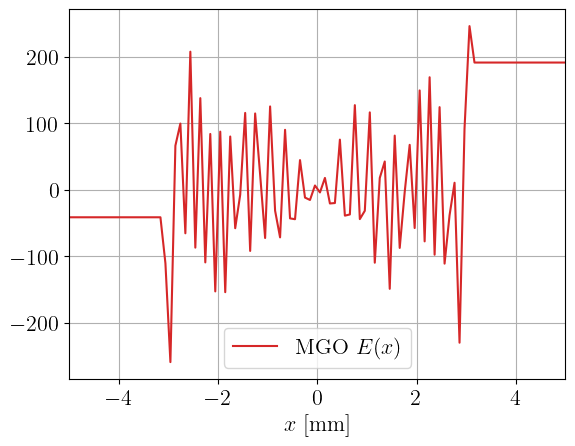

In [40]:
plt.plot(xi * 1e3, np.real(mgo_field(xi)), '-', color='tab:red', label='MGO $E(x)$')
plt.grid()
plt.xlim(-5, 5)
plt.legend()
plt.xlabel('$x$ [mm]')

In [20]:

branch_masks, ray_field = mgo.get_go_field_1D(t, zs, phi0, i_start, i_end)
field = mgo.superpose_ray_fields(phi0=phi0, x0=x0, xs=xs, branch_masks=branch_masks, ray_field=ray_field, i_start=i_start, i_end=i_end)
go_results.append({'field': field, 't': t, 'xs': xs, 'ks': ks, 'zs': zs, 'nt': nt, 'x0': x0, 'k0': k0, 'const_T': const_T, 'branch_masks': branch_masks, 'ray_field': ray_field})

NameError: name 'go_results' is not defined

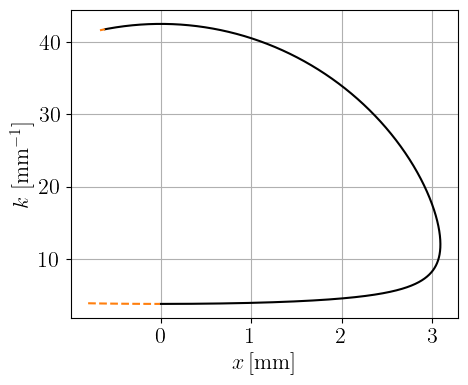

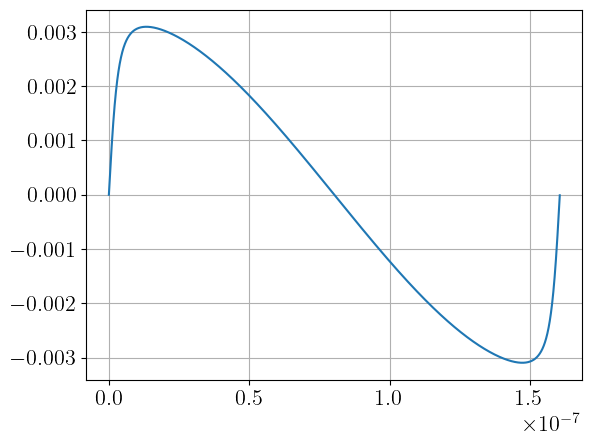

In [23]:
plt.plot(t[i_start:i_end], xs[i_start:i_end])
plt.grid()
# plt.plot(t, ks)
# plt.xlim(-10e-3,10e-3)